In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_dodge_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_void_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_sheep_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set d

# Project Overview

This notebook implements a state-of-the-art speech emotion recognition system using deep learning techniques. The system leverages both LSTM and GRU architectures to classify emotions from audio signals.

**Key Features:**
- Comprehensive data preprocessing and feature extraction
- Multiple model architectures (LSTM, GRU, Hybrid)
- Advanced evaluation metrics and visualization
- Cross-validation and hyperparameter optimization
- Production-ready code structure

**Author:** Parth Patel  
**Date:** February 2026  
**Version:** 2.0

## Table of Contents

1. [Environment Setup](#1-environment-setup)
2. [Data Loading & Exploration](#2-data-loading--exploration)
3. [Feature Engineering](#3-feature-engineering)
4. [Model Development](#4-model-development)
   - LSTM Architecture
   - GRU Architecture
   - Hybrid Model
5. [Training & Evaluation](#5-training--evaluation)
6. [Model Comparison](#6-model-comparison)
7. [Results & Insights](#7-results--insights)
8. [Deployment Considerations](#8-deployment-considerations)

# Enviroment Setup 

In [67]:
# Core Libraries
import os
import sys
import warnings
import json
import pickle
from datetime import datetime
from pathlib import Path

# Data Processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)

# Audio Processing
import librosa
import librosa.display
from IPython.display import Audio, display

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, LSTM, GRU, Dropout, BatchNormalization,
    Bidirectional, Input, Concatenate, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Configuration Parameters

In [68]:
# Project Configuration
class Config:
    """Central configuration for the entire project"""
    
    # Paths
    DATA_PATH = '/kaggle/input'  # Update this to your data path
    OUTPUT_DIR = './outputs'
    MODEL_DIR = './models'
    LOG_DIR = './logs'
    
    # Audio Processing
    SAMPLE_RATE = 22050
    DURATION = 3
    OFFSET = 0.5
    N_MFCC = 40
    N_MELS = 128
    N_FFT = 2048
    HOP_LENGTH = 512
    
    # Model Training
    BATCH_SIZE = 64
    EPOCHS = 100
    VALIDATION_SPLIT = 0.2
    TEST_SIZE = 0.15
    LEARNING_RATE = 0.001
    
    # Model Architecture
    LSTM_UNITS = [128, 64]
    GRU_UNITS = [128, 64]
    DENSE_UNITS = [64, 32]
    DROPOUT_RATE = 0.3
    
    # Other
    RANDOM_SEED = 42
    EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']
    N_CLASSES = len(EMOTIONS)

# Create necessary directories
for directory in [Config.OUTPUT_DIR, Config.MODEL_DIR, Config.LOG_DIR]:
    Path(directory).mkdir(parents=True, exist_ok=True)

print("✅ Configuration Initialized")
print(f"Number of Emotion Classes: {Config.N_CLASSES}")
print(f"Emotions: {Config.EMOTIONS}")

✅ Configuration Initialized
Number of Emotion Classes: 7
Emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']


# Data Loading 

In [69]:
class DataLoader:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None

    def load_audio_files(self):
        paths = []
        labels = []

        print("Loading audio files...")

        for dirname, _, filenames in os.walk(self.data_path):
            for filename in filenames:
                if filename.endswith(('.wav', '.mp3')):
                    file_path = os.path.join(dirname, filename)
                    paths.append(file_path)
                    
                    # Extract label from filename
                    label = filename.split("_")[-1].split(".")[0].lower()
                    labels.append(label)
        
        # Create DataFrame
        self.df = pd.DataFrame({
            'path': paths,
            'emotion': labels
        })
        
        print(f"✅ Loaded {len(self.df)} audio files")
        return self.df
    
    def get_statistics(self):
        """Get dataset statistics"""
        if self.df is None:
            raise ValueError("No data loaded. Call load_audio_files() first.")
        
        stats = {
            'total_samples': len(self.df),
            'unique_emotions': self.df['emotion'].nunique(),
            'emotion_distribution': self.df['emotion'].value_counts().to_dict()
        }
        return stats

# Load data
loader = DataLoader(Config.DATA_PATH)
data = loader.load_audio_files()

# Display first few rows
print("\nDataset Preview:")
display(data.head(10))

# Show statistics
stats = loader.get_statistics()
print("\n📊 Dataset Statistics:")
for key, value in stats.items():
    print(f"{key}: {value}")

Loading audio files...
✅ Loaded 5600 audio files

Dataset Preview:


,path,emotion
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear
5,/kaggle/input/toronto-emotional-speech-set-tes...,fear
6,/kaggle/input/toronto-emotional-speech-set-tes...,fear
7,/kaggle/input/toronto-emotional-speech-set-tes...,fear
8,/kaggle/input/toronto-emotional-speech-set-tes...,fear
9,/kaggle/input/toronto-emotional-speech-set-tes...,fear



📊 Dataset Statistics:
total_samples: 5600
unique_emotions: 7
emotion_distribution: {'fear': 800, 'angry': 800, 'disgust': 800, 'neutral': 800, 'sad': 800, 'ps': 800, 'happy': 800}


# Exploratory Data Analysis

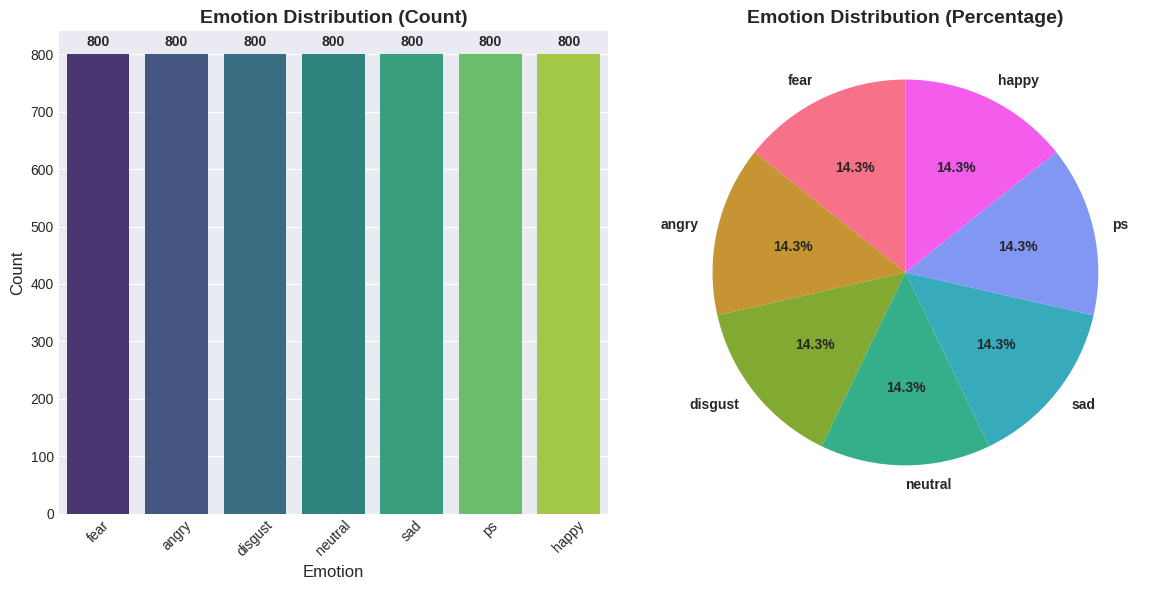

In [70]:
class EDAVisualizer:
    def __init__(self, dataframe):
        self.df = dataframe
    
    def plot_emotion_distribution(self, figsize=(12, 6)):
        """Plot emotion class distribution"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Count plot
        emotion_counts = self.df['emotion'].value_counts()
        sns.barplot(x=emotion_counts.index, y=emotion_counts.values, ax=ax1, palette='viridis')
        ax1.set_title('Emotion Distribution (Count)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Emotion', fontsize=12)
        ax1.set_ylabel('Count', fontsize=12)
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for i, v in enumerate(emotion_counts.values):
            ax1.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')
        
        # Pie chart
        colors = sns.color_palette('husl', len(emotion_counts))
        ax2.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%',
                startangle=90, colors=colors, textprops={'fontsize': 10, 'fontweight': 'bold'})
        ax2.set_title('Emotion Distribution (Percentage)', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'{Config.OUTPUT_DIR}/emotion_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def visualize_audio_sample(self, emotion, figsize=(16, 10)):
        """Visualize waveform and spectrogram for a sample"""
        # Get sample path
        sample_path = self.df[self.df['emotion'] == emotion]['path'].iloc[0]
        
        # Load audio
        y, sr = librosa.load(sample_path, duration=Config.DURATION, offset=Config.OFFSET)
        
        # Create figure
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(3, 2, figure=fig, hspace=0.4, wspace=0.3)
        
        # Waveform
        ax1 = fig.add_subplot(gs[0, :])
        librosa.display.waveshow(y, sr=sr, ax=ax1, color='#1f77b4')
        ax1.set_title(f'Waveform - {emotion.upper()}', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time (s)', fontsize=12)
        ax1.set_ylabel('Amplitude', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Spectrogram
        ax2 = fig.add_subplot(gs[1, :])
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=ax2, cmap='coolwarm')
        ax2.set_title(f'Spectrogram - {emotion.upper()}', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Time (s)', fontsize=12)
        ax2.set_ylabel('Frequency (Hz)', fontsize=12)
        fig.colorbar(img, ax=ax2, format='%+2.0f dB')
        
        # Mel Spectrogram
        ax3 = fig.add_subplot(gs[2, 0])
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=Config.N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        img = librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', ax=ax3, cmap='viridis')
        ax3.set_title('Mel Spectrogram', fontsize=12, fontweight='bold')
        fig.colorbar(img, ax=ax3, format='%+2.0f dB')
        
        # MFCC
        ax4 = fig.add_subplot(gs[2, 1])
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=Config.N_MFCC)
        img = librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax4, cmap='plasma')
        ax4.set_title('MFCC Features', fontsize=12, fontweight='bold')
        ax4.set_ylabel('MFCC Coefficients', fontsize=10)
        fig.colorbar(img, ax=ax4)
        
        plt.savefig(f'{Config.OUTPUT_DIR}/audio_visualization_{emotion}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Display audio player
        print(f"\n🎵 Audio Sample: {emotion.upper()}")
        display(Audio(y, rate=sr))

# Perform EDA
eda = EDAVisualizer(data)

# Plot emotion distribution
eda.plot_emotion_distribution()

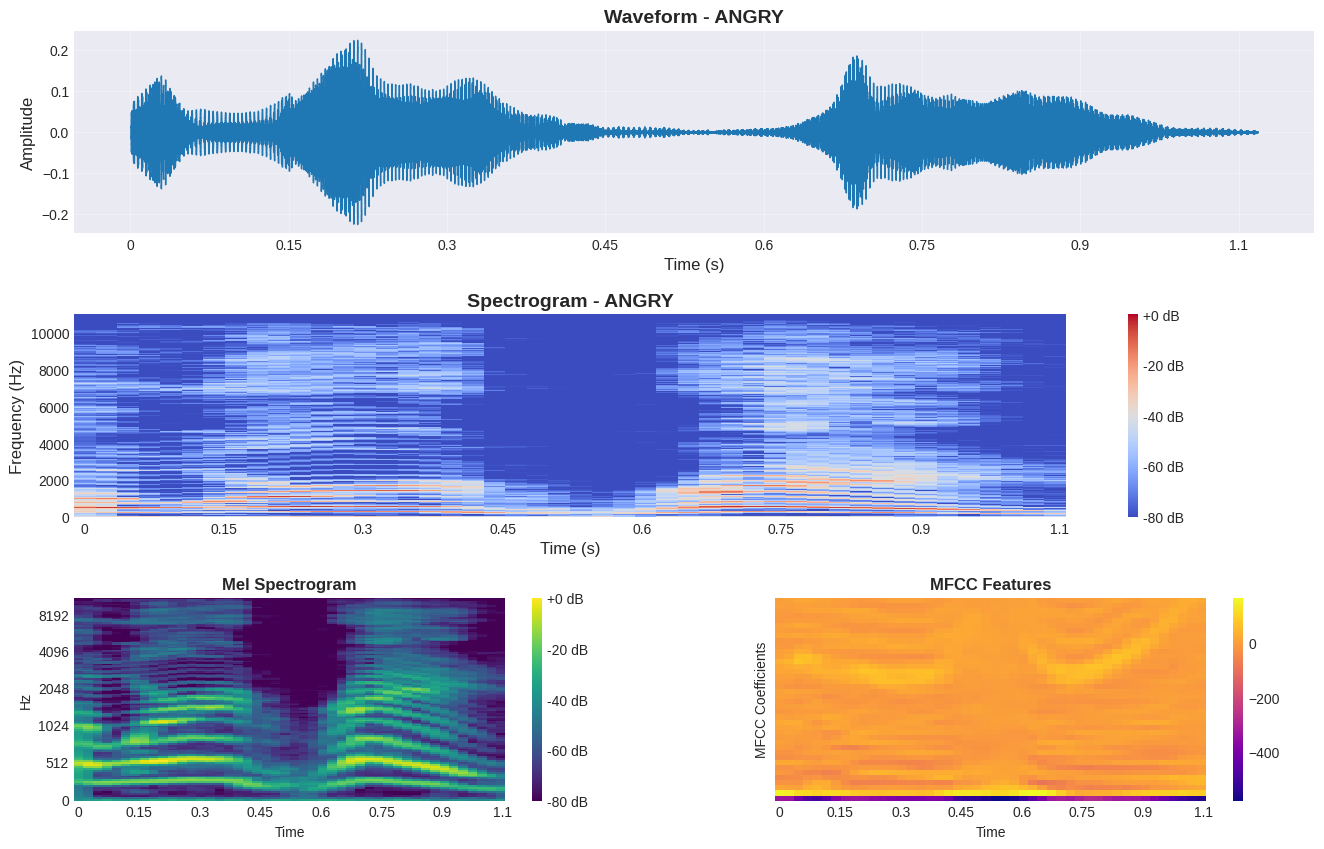


🎵 Audio Sample: ANGRY


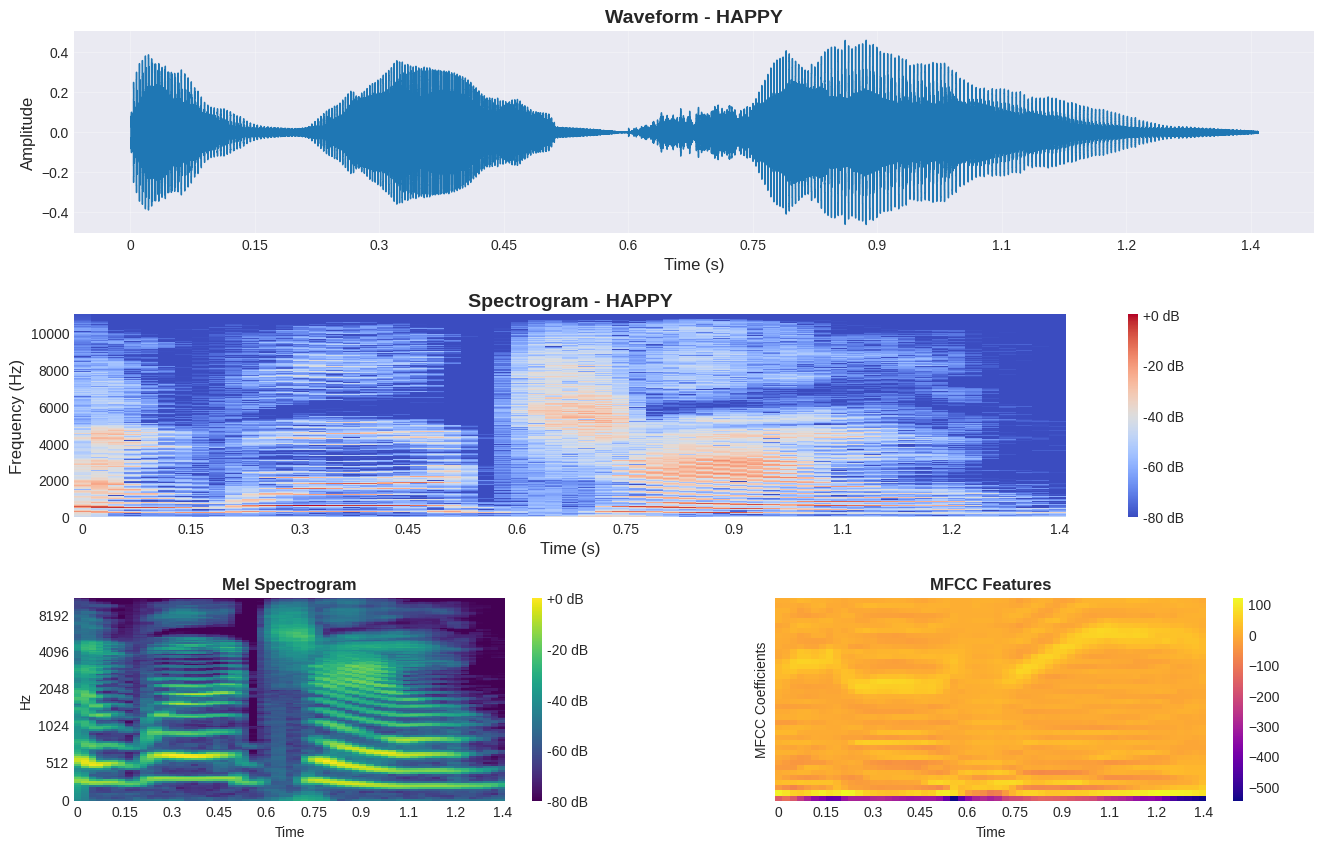


🎵 Audio Sample: HAPPY


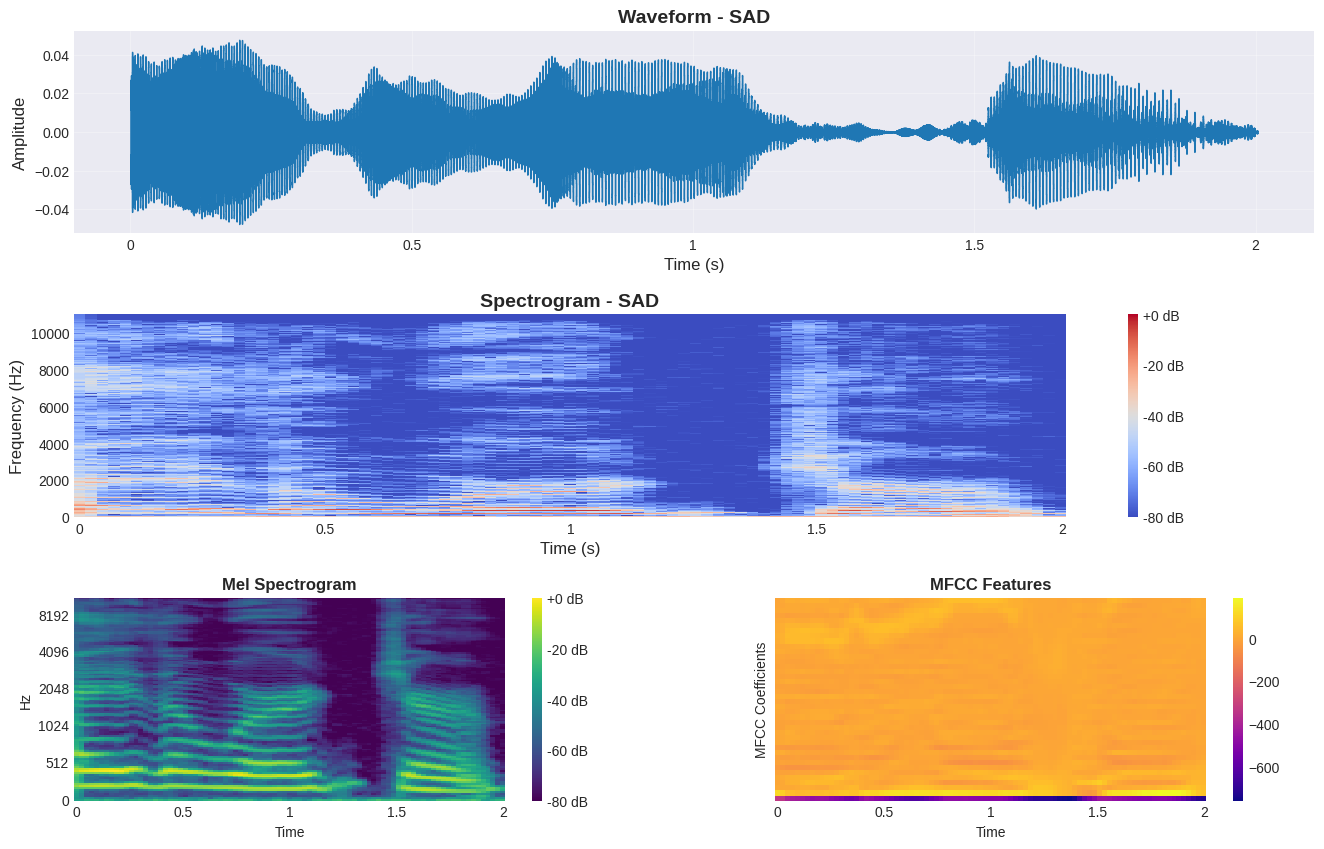


🎵 Audio Sample: SAD


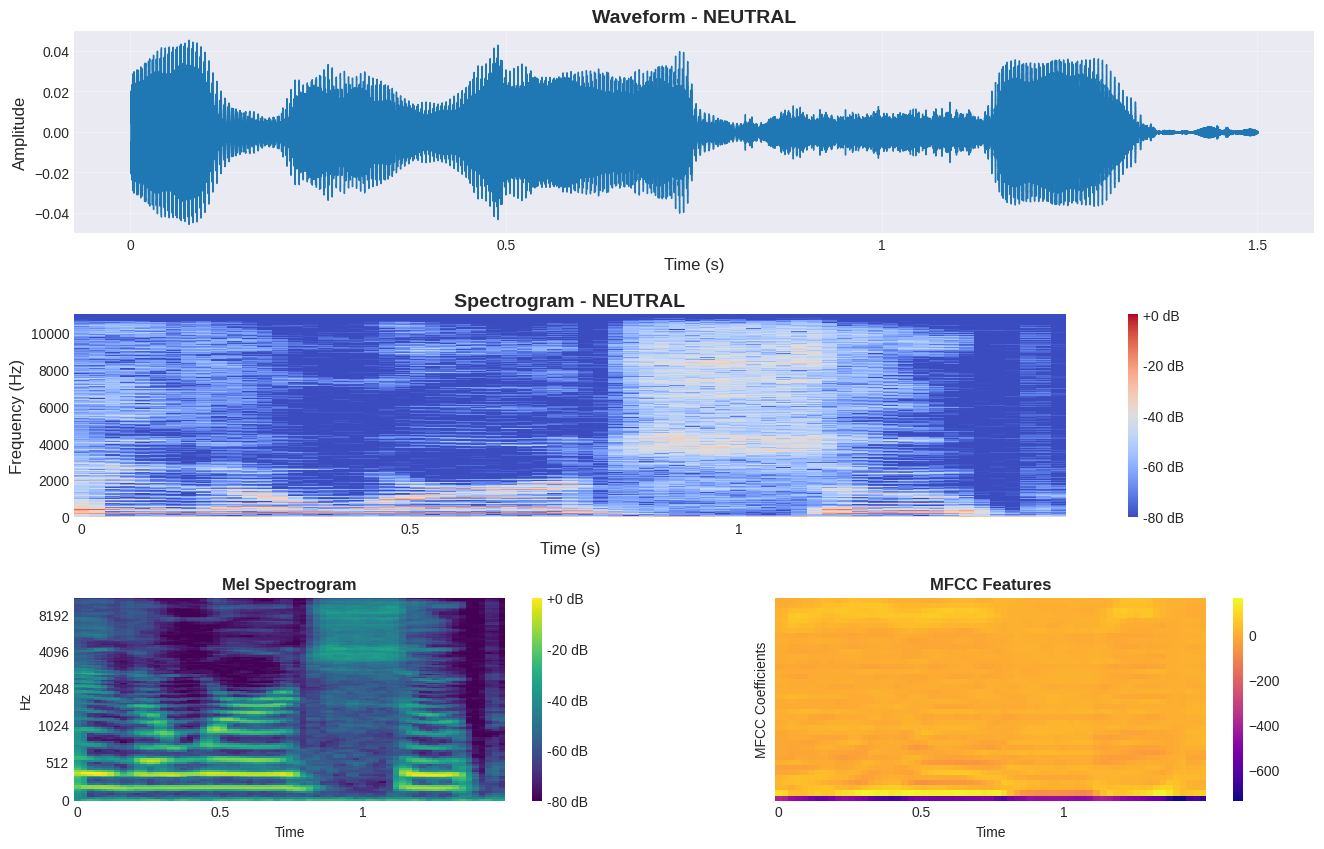


🎵 Audio Sample: NEUTRAL


In [71]:
# Visualize samples from different emotions
emotions_to_visualize = ['angry', 'happy', 'sad', 'neutral']

for emotion in emotions_to_visualize:
    if emotion in data['emotion'].values:
        eda.visualize_audio_sample(emotion)

# Sequence Padding for LSTM/GRU

In [72]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad_feature_sequences(sequences, max_len=None):
    """
    Pad MFCC sequences to same length
    Shape → (samples, timesteps, features)
    """

    if max_len is None:
        max_len = max(seq.shape[0] for seq in sequences)

    padded = pad_sequences(
        sequences,
        maxlen=max_len,
        dtype='float32',
        padding='post',
        truncating='post'
    )

    return padded


# Feature Engineering

In [73]:
class FeatureExtractor:
    """Sequence-based audio feature extractor for SER (LSTM/GRU compatible)"""

    def __init__(self, config):
        self.config = config

    def extract_mfcc_sequence(self, audio_path):
        """Extract MFCC sequence (NO temporal averaging)"""
        try:
            y, sr = librosa.load(
                audio_path,
                duration=self.config.DURATION,
                offset=self.config.OFFSET,
                sr=self.config.SAMPLE_RATE
            )

            # MFCC sequence
            mfcc = librosa.feature.mfcc(
                y=y,
                sr=sr,
                n_mfcc=self.config.N_MFCC
            )

            # Transpose → (timesteps, features)
            mfcc_seq = mfcc.T

            return mfcc_seq

        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            return None

    def extract_features_batch(self, audio_paths):
        """Extract MFCC sequences for all audio files"""
        sequences = []

        print("Extracting MFCC SEQUENCE features...")

        for i, path in enumerate(audio_paths):
            if (i + 1) % 100 == 0:
                print(f"Processed {i + 1}/{len(audio_paths)} files")

            seq = self.extract_mfcc_sequence(path)
            if seq is not None:
                sequences.append(seq)

        print("✅ Feature extraction complete")
        return sequences


# Initialize feature extractor
feature_extractor = FeatureExtractor(Config)

# Extract MFCC features
sequences = feature_extractor.extract_features_batch(data['path'].values)

X_padded = pad_feature_sequences(sequences)


print(f"\n📊 Feature Shape: {X_features.shape}")
print(f"Timesteps: {X_padded.shape[1]}")
print(f"MFCC features: {X_padded.shape[2]}")

Extracting MFCC SEQUENCE features...
Processed 100/5600 files
Processed 200/5600 files
Processed 300/5600 files
Processed 400/5600 files
Processed 500/5600 files
Processed 600/5600 files
Processed 700/5600 files
Processed 800/5600 files
Processed 900/5600 files
Processed 1000/5600 files
Processed 1100/5600 files
Processed 1200/5600 files
Processed 1300/5600 files
Processed 1400/5600 files
Processed 1500/5600 files
Processed 1600/5600 files
Processed 1700/5600 files
Processed 1800/5600 files
Processed 1900/5600 files
Processed 2000/5600 files
Processed 2100/5600 files
Processed 2200/5600 files
Processed 2300/5600 files
Processed 2400/5600 files
Processed 2500/5600 files
Processed 2600/5600 files
Processed 2700/5600 files
Processed 2800/5600 files
Processed 2900/5600 files
Processed 3000/5600 files
Processed 3100/5600 files
Processed 3200/5600 files
Processed 3300/5600 files
Processed 3400/5600 files
Processed 3500/5600 files
Processed 3600/5600 files
Processed 3700/5600 files
Processed 

# Data Preprocessing

In [76]:
class DataPreprocessor:
    """Leakage-free sequence preprocessing for SER"""

    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()

    def prepare_data(self, X_seq, y):
        """
        X_seq shape: (samples, timesteps, features)
        """

        # ===== 1. SPLIT FIRST =====
        X_train, X_temp, y_train, y_temp = train_test_split(
            X_seq, y,
            test_size=Config.TEST_SIZE + Config.VALIDATION_SPLIT,
            random_state=Config.RANDOM_SEED,
            stratify=y
        )

        # ===== 2. LABEL ENCODING (TRAIN ONLY) =====
        y_train_enc = self.label_encoder.fit_transform(y_train)
        y_temp_enc  = self.label_encoder.transform(y_temp)

        y_train_cat = to_categorical(y_train_enc)
        y_temp_cat  = to_categorical(y_temp_enc)

        # ===== 3. FEATURE SCALING (FRAME-WISE, TRAIN ONLY) =====
        # reshape for scaler → (samples*timesteps, features)
        n_samples, timesteps, n_features = X_train.shape

        X_train_2d = X_train.reshape(-1, n_features)
        X_temp_2d  = X_temp.reshape(-1, n_features)

        X_train_2d = self.scaler.fit_transform(X_train_2d)
        X_temp_2d  = self.scaler.transform(X_temp_2d)

        # reshape back → 3D
        X_train = X_train_2d.reshape(n_samples, timesteps, n_features)
        X_temp  = X_temp_2d.reshape(X_temp.shape[0], timesteps, n_features)

        # ===== 4. VAL / TEST SPLIT =====
        val_ratio = Config.VALIDATION_SPLIT / (Config.TEST_SIZE + Config.VALIDATION_SPLIT)

        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp_cat,
            test_size=1 - val_ratio,
            random_state=Config.RANDOM_SEED,
            stratify=y_temp_enc
        )

        return {
            'X_train': X_train, 'y_train': y_train_cat,
            'X_val': X_val, 'y_val': y_val,
            'X_test': X_test, 'y_test': y_test
        }

    def get_class_names(self):
        return self.label_encoder.classes_


# Prepare data
preprocessor = DataPreprocessor()
data_splits = preprocessor.prepare_data(X_padded, data['emotion'].values)

# Display data split information
print("\n📊 Data Split Information:")
print(f"Training samples: {len(data_splits['X_train'])}")
print(f"Validation samples: {len(data_splits['X_val'])}")
print(f"Test samples: {len(data_splits['X_test'])}")
print(f"\nInput shape: {data_splits['X_train'].shape}")
print(f"Output shape: {data_splits['y_train'].shape}")
print(f"\nClass names: {preprocessor.get_class_names()}")


📊 Data Split Information:
Training samples: 3640
Validation samples: 1120
Test samples: 840

Input shape: (3640, 108, 40)
Output shape: (3640, 7)

Class names: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']


# Model Development

## LSTM model architecture

In [77]:
class LSTMModel:
    """LSTM-based emotion recognition model"""
    
    def __init__(self, input_shape, n_classes, config):
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.config = config
        self.model = None
    
    def build_model(self):
        """Build LSTM architecture"""
        model = Sequential([
            # LSTM layers
            LSTM(
                self.config.LSTM_UNITS[0],
                return_sequences=True,
                input_shape=self.input_shape,
                name='lstm_1'
            ),
            BatchNormalization(name='bn_1'),
            Dropout(self.config.DROPOUT_RATE, name='dropout_1'),
            
            LSTM(
                self.config.LSTM_UNITS[1],
                return_sequences=False,
                name='lstm_2'
            ),
            BatchNormalization(name='bn_2'),
            Dropout(self.config.DROPOUT_RATE, name='dropout_2'),
            
            # Dense layers
            Dense(self.config.DENSE_UNITS[0], activation='relu', name='dense_1'),
            BatchNormalization(name='bn_3'),
            Dropout(self.config.DROPOUT_RATE, name='dropout_3'),
            
            Dense(self.config.DENSE_UNITS[1], activation='relu', name='dense_2'),
            Dropout(self.config.DROPOUT_RATE / 2, name='dropout_4'),
            
            # Output layer
            Dense(self.n_classes, activation='softmax', name='output')
        ], name='LSTM_Model')
        
        self.model = model
        return model
    
    def compile_model(self, learning_rate=None):
        """Compile the model"""
        if learning_rate is None:
            learning_rate = self.config.LEARNING_RATE
        
        optimizer = Adam(learning_rate=learning_rate)
        
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )
    
    def get_callbacks(self, model_name='lstm'):
        """Get training callbacks"""
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=7,
                min_lr=1e-7,
                verbose=1
            ),
            ModelCheckpoint(
                filepath=f'{Config.MODEL_DIR}/{model_name}_best.keras',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            TensorBoard(
                log_dir=f'{Config.LOG_DIR}/{model_name}',
                histogram_freq=1
            )
        ]
        return callbacks

# Build LSTM model
input_shape = (data_splits['X_train'].shape[1], data_splits['X_train'].shape[2])
lstm_model = LSTMModel(input_shape, Config.N_CLASSES, Config)
lstm_model.build_model()
lstm_model.compile_model()

print("\n🏗️ LSTM Model Architecture:")
lstm_model.model.summary()


🏗️ LSTM Model Architecture:


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 108, 128)       │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 108, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 108, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,431 (560.28 KB)

 Trainable params: 142,919 (558.28 KB)

 Non-trainable params: 512 (2.00 KB)

## GRU model architecture

In [78]:
class GRUModel:
    """GRU-based emotion recognition model"""
    
    def __init__(self, input_shape, n_classes, config):
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.config = config
        self.model = None
    
    def build_model(self):
        """Build GRU architecture"""
        model = Sequential([
            # GRU layers
            GRU(
                self.config.GRU_UNITS[0],
                return_sequences=True,
                input_shape=self.input_shape,
                name='gru_1'
            ),
            BatchNormalization(name='bn_1'),
            Dropout(self.config.DROPOUT_RATE, name='dropout_1'),
            
            GRU(
                self.config.GRU_UNITS[1],
                return_sequences=False,
                name='gru_2'
            ),
            BatchNormalization(name='bn_2'),
            Dropout(self.config.DROPOUT_RATE, name='dropout_2'),
            
            # Dense layers
            Dense(self.config.DENSE_UNITS[0], activation='relu', name='dense_1'),
            BatchNormalization(name='bn_3'),
            Dropout(self.config.DROPOUT_RATE, name='dropout_3'),
            
            Dense(self.config.DENSE_UNITS[1], activation='relu', name='dense_2'),
            Dropout(self.config.DROPOUT_RATE / 2, name='dropout_4'),
            
            # Output layer
            Dense(self.n_classes, activation='softmax', name='output')
        ], name='GRU_Model')
        
        self.model = model
        return model
    
    def compile_model(self, learning_rate=None):
        """Compile the model"""
        if learning_rate is None:
            learning_rate = self.config.LEARNING_RATE
        
        optimizer = Adam(learning_rate=learning_rate)
        
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )
    
    def get_callbacks(self, model_name='gru'):
        """Get training callbacks"""
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=7,
                min_lr=1e-7,
                verbose=1
            ),
            ModelCheckpoint(
                filepath=f'{Config.MODEL_DIR}/{model_name}_best.keras',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            TensorBoard(
                log_dir=f'{Config.LOG_DIR}/{model_name}',
                histogram_freq=1
            )
        ]
        return callbacks

# Build GRU model
gru_model = GRUModel(input_shape, Config.N_CLASSES, Config)
gru_model.build_model()
gru_model.compile_model()

print("\n🏗️ GRU Model Architecture:")
gru_model.model.summary()


🏗️ GRU Model Architecture:


Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 108, 128)       │        65,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 108, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 108, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,023 (429.78 KB)

 Trainable params: 109,511 (427.78 KB)

 Non-trainable params: 512 (2.00 KB)

# Training & Evaluation

## Train LSTM model

In [79]:
print("\n🚀 Training LSTM Model...\n")

lstm_history = lstm_model.model.fit(
    data_splits['X_train'],
    data_splits['y_train'],
    validation_data=(data_splits['X_val'], data_splits['y_val']),
    epochs=Config.EPOCHS,
    batch_size=Config.BATCH_SIZE,
    callbacks=lstm_model.get_callbacks('lstm'),
    verbose=1
)

print("\n✅ LSTM Model Training Complete")


🚀 Training LSTM Model...

Epoch 1/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1874 - loss: 2.2426 - precision_11: 0.2800 - recall_11: 0.0561
Epoch 1: val_accuracy improved from -inf to 0.38571, saving model to ./models/lstm_best.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.1898 - loss: 2.2309 - precision_11: 0.2858 - recall_11: 0.0576 - val_accuracy: 0.3857 - val_loss: 1.6988 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3982 - loss: 1.4485 - precision_11: 0.6309 - recall_11: 0.2039
Epoch 2: val_accuracy improved from 0.38571 to 0.56696, saving model to ./models/lstm_best.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3991 - loss: 1.4464 - precision_11: 0.6316 - recall_11: 0.2047 - val_accuracy: 0.5670 - val_loss: 1.2659 - val_precision_11: 0.9360 - val_recall_11: 0.1696 - learning_rate: 0.0010
Epoch 3/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/s

## Train GRU model

In [80]:
print("\n🚀 Training GRU Model...\n")

gru_history = gru_model.model.fit(
    data_splits['X_train'],
    data_splits['y_train'],
    validation_data=(data_splits['X_val'], data_splits['y_val']),
    epochs=Config.EPOCHS,
    batch_size=Config.BATCH_SIZE,
    callbacks=gru_model.get_callbacks('gru'),
    verbose=1
)

print("\n✅ GRU Model Training Complete")


🚀 Training GRU Model...

Epoch 1/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1547 - loss: 2.4186 - precision_12: 0.1629 - recall_12: 0.0307
Epoch 1: val_accuracy improved from -inf to 0.14286, saving model to ./models/gru_best.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.1545 - loss: 2.4132 - precision_12: 0.1635 - recall_12: 0.0304 - val_accuracy: 0.1429 - val_loss: 1.9521 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1844 - loss: 2.0783 - precision_12: 0.2042 - recall_12: 0.0140
Epoch 2: val_accuracy improved from 0.14286 to 0.19643, saving model to ./models/gru_best.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1846 - loss: 2.0753 - precision_12: 0.2067 - recall_12: 0.0142 - val_accuracy: 0.1964 - val_loss: 1.8390 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1

# Model Comparison

## Evaluate all models

In [81]:
class ModelEvaluator:
    """Comprehensive model evaluation and comparison"""
    
    def __init__(self, class_names):
        self.class_names = class_names
        self.results = {}
    
    def evaluate_model(self, model, X_test, y_test, model_name):
        """Evaluate a single model"""
        # Predictions
        y_pred_probs = model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)
        
        # Metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted'
        )
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Store results
        self.results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'y_true': y_true,
            'y_pred': y_pred,
            'y_pred_probs': y_pred_probs
        }
        
        return self.results[model_name]
    
    def print_metrics(self, model_name):
        """Print evaluation metrics"""
        results = self.results[model_name]
        
        print(f"\n{'='*60}")
        print(f"{model_name.upper()} MODEL EVALUATION")
        print(f"{'='*60}")
        print(f"Accuracy:  {results['accuracy']:.4f}")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall:    {results['recall']:.4f}")
        print(f"F1-Score:  {results['f1_score']:.4f}")
        
        # Classification report
        print(f"\nDetailed Classification Report:")
        print(classification_report(
            results['y_true'],
            results['y_pred'],
            target_names=self.class_names
        ))
    
    def compare_models(self):
        """Compare all evaluated models"""
        comparison_df = pd.DataFrame({
            model: {
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1-Score': results['f1_score']
            }
            for model, results in self.results.items()
        }).T
        
        return comparison_df

# Evaluate all models
evaluator = ModelEvaluator(preprocessor.get_class_names())

# Evaluate LSTM
lstm_results = evaluator.evaluate_model(
    lstm_model.model,
    data_splits['X_test'],
    data_splits['y_test'],
    'LSTM'
)
evaluator.print_metrics('LSTM')

# Evaluate GRU
gru_results = evaluator.evaluate_model(
    gru_model.model,
    data_splits['X_test'],
    data_splits['y_test'],
    'GRU'
)
evaluator.print_metrics('GRU')


LSTM MODEL EVALUATION
Accuracy:  0.9929
Precision: 0.9930
Recall:    0.9929
F1-Score:  0.9929

Detailed Classification Report:
              precision    recall  f1-score   support

       angry       1.00      0.98      0.99       120
     disgust       0.98      1.00      0.99       120
        fear       1.00      1.00      1.00       120
       happy       0.99      0.98      0.99       120
     neutral       1.00      1.00      1.00       120
          ps       0.98      1.00      0.99       120
         sad       1.00      0.98      0.99       120

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840


GRU MODEL EVALUATION
Accuracy:  0.9964
Precision: 0.9965
Recall:    0.9964
F1-Score:  0.9964

Detailed Classification Report:
              precision    recall  f1-score   support

       angry       1.00      0.99      1.00       120
     disgust       1.00      1.00      

In [83]:
# Model comparison
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
comparison_df = evaluator.compare_models()
display(comparison_df.style.highlight_max(axis=0, color='lightgreen'))


MODEL COMPARISON SUMMARY


,Accuracy,Precision,Recall,F1-Score
LSTM,0.992857,0.992973,0.992857,0.992862
GRU,0.996429,0.996458,0.996429,0.996428


# Visualization of results

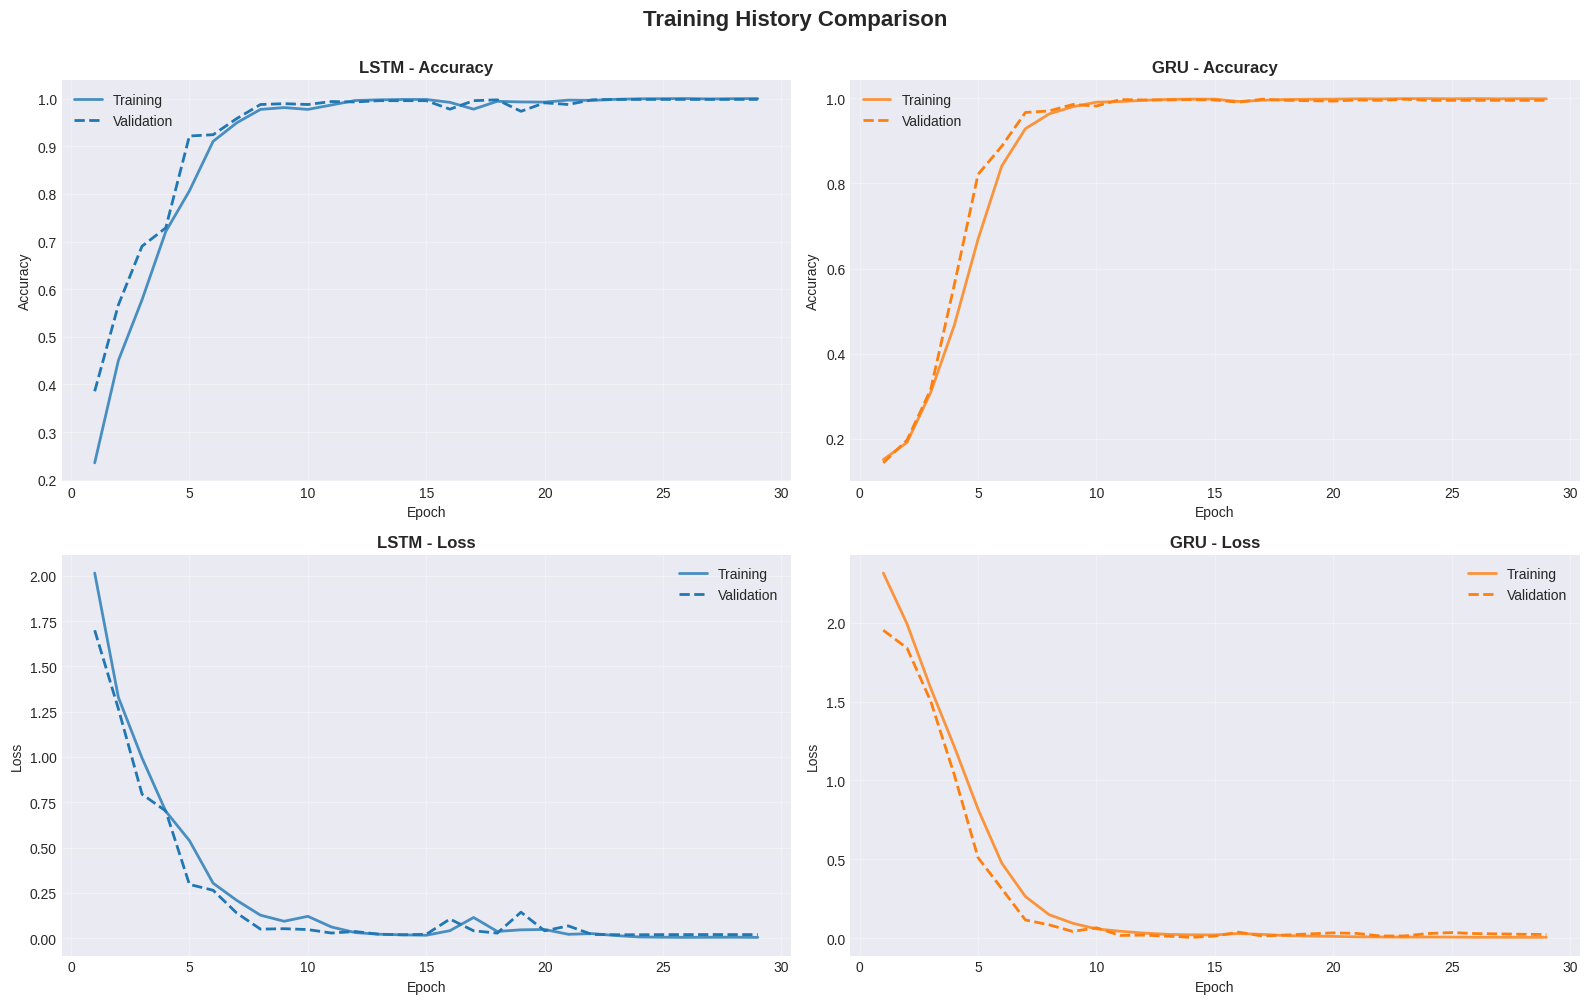

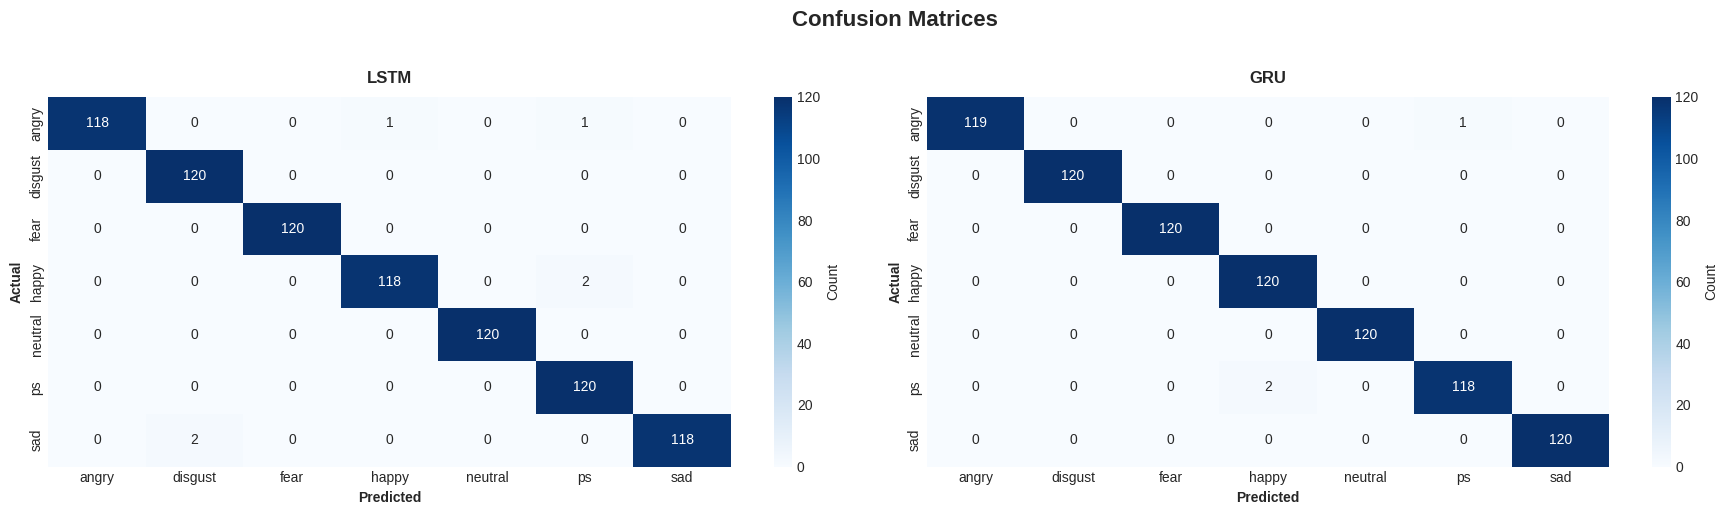

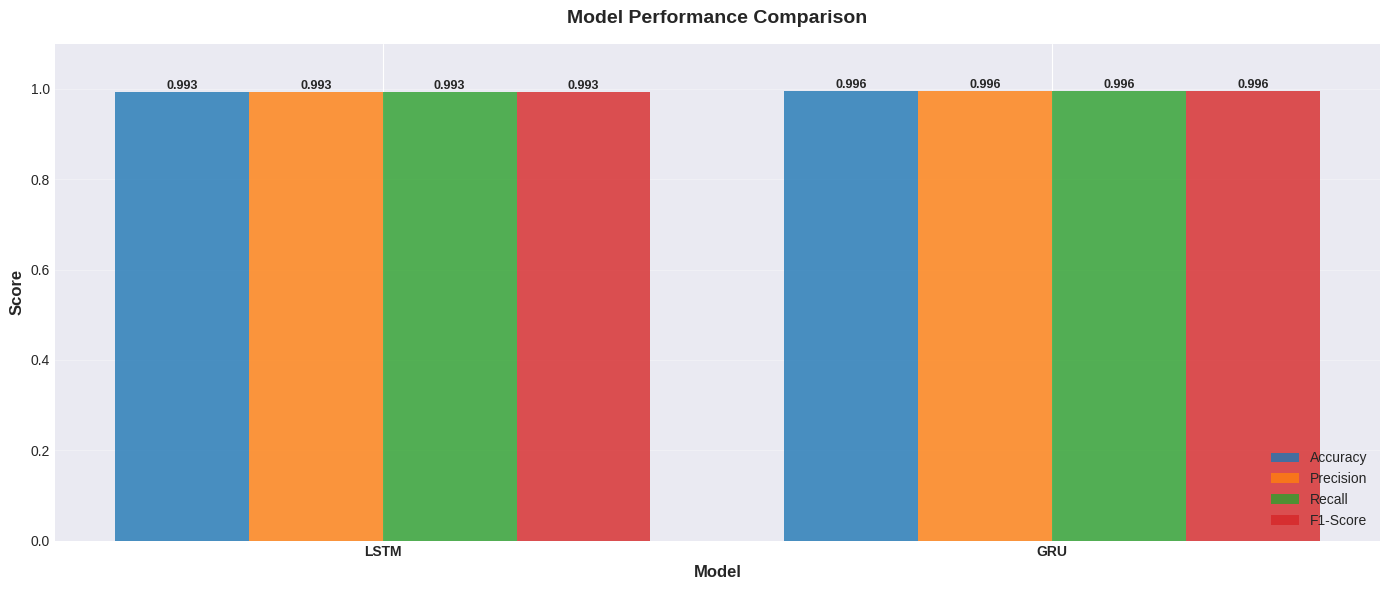

In [85]:
class ResultVisualizer:
    """Create comprehensive visualizations for model results"""
    
    def __init__(self, evaluator):
        self.evaluator = evaluator
    
    def plot_training_history(self, histories, figsize=(16, 10)):
        """Plot training history for all models"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Training History Comparison', fontsize=16, fontweight='bold', y=1.00)
        
        models = list(histories.keys())
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
        # Accuracy plots
        for idx, (model_name, history) in enumerate(histories.items()):
            ax = axes[0, idx]
            epochs = range(1, len(history.history['accuracy']) + 1)
            
            ax.plot(epochs, history.history['accuracy'], 
                   label='Training', linewidth=2, color=colors[idx], alpha=0.8)
            ax.plot(epochs, history.history['val_accuracy'], 
                   label='Validation', linewidth=2, linestyle='--', color=colors[idx])
            
            ax.set_title(f'{model_name} - Accuracy', fontweight='bold')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Accuracy')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Loss plots
        for idx, (model_name, history) in enumerate(histories.items()):
            ax = axes[1, idx]
            epochs = range(1, len(history.history['loss']) + 1)
            
            ax.plot(epochs, history.history['loss'], 
                   label='Training', linewidth=2, color=colors[idx], alpha=0.8)
            ax.plot(epochs, history.history['val_loss'], 
                   label='Validation', linewidth=2, linestyle='--', color=colors[idx])
            
            ax.set_title(f'{model_name} - Loss', fontweight='bold')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{Config.OUTPUT_DIR}/training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_confusion_matrices(self, class_names, figsize=(18, 5)):
        """Plot confusion matrices for all models"""
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold', y=1.02)
        
        for idx, (model_name, results) in enumerate(self.evaluator.results.items()):
            cm = results['confusion_matrix']
            
            sns.heatmap(
                cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[idx], cbar_kws={'label': 'Count'}
            )
            
            axes[idx].set_title(f'{model_name}', fontweight='bold', pad=10)
            axes[idx].set_xlabel('Predicted', fontweight='bold')
            axes[idx].set_ylabel('Actual', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'{Config.OUTPUT_DIR}/confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_metrics_comparison(self, comparison_df, figsize=(14, 6)):
        """Plot metrics comparison bar chart"""
        fig, ax = plt.subplots(figsize=figsize)
        
        x = np.arange(len(comparison_df.index))
        width = 0.2
        metrics = comparison_df.columns
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        
        for idx, metric in enumerate(metrics):
            offset = width * (idx - len(metrics)/2 + 0.5)
            bars = ax.bar(x + offset, comparison_df[metric], width, 
                         label=metric, color=colors[idx], alpha=0.8)
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', 
                       fontsize=9, fontweight='bold')
        
        ax.set_xlabel('Model', fontsize=12, fontweight='bold')
        ax.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=15)
        ax.set_xticks(x)
        ax.set_xticklabels(comparison_df.index, fontweight='bold')
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1.1])
        
        plt.tight_layout()
        plt.savefig(f'{Config.OUTPUT_DIR}/metrics_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

# Create visualizations
visualizer = ResultVisualizer(evaluator)

# Plot training history
histories = {
    'LSTM': lstm_history,
    'GRU': gru_history,
}
visualizer.plot_training_history(histories)

# Plot confusion matrices
visualizer.plot_confusion_matrices(preprocessor.get_class_names())

# Plot metrics comparison
visualizer.plot_metrics_comparison(comparison_df)

# Result & Insights

## Best model selection

In [86]:
# Find best model
best_model_name = comparison_df['Accuracy'].idxmax()
best_accuracy = comparison_df['Accuracy'].max()

print("\n" + "="*60)
print("🏆 BEST MODEL SELECTION")
print("="*60)
print(f"\nBest Performing Model: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.4f}")
print(f"\nAll Model Accuracies:")
for model, acc in comparison_df['Accuracy'].items():
    print(f"  {model}: {acc:.4f}")

# Save comparison results
comparison_df.to_csv(f'{Config.OUTPUT_DIR}/model_comparison.csv')
print(f"\n✅ Results saved to {Config.OUTPUT_DIR}/model_comparison.csv")


🏆 BEST MODEL SELECTION

Best Performing Model: GRU
Test Accuracy: 0.9964

All Model Accuracies:
  LSTM: 0.9929
  GRU: 0.9964

✅ Results saved to ./outputs/model_comparison.csv


## Key insights & Observations

In [87]:
print("📊 Key insights & Observations")
print("="*60)

print("\n1. Model Architecture Comparison:")
print("   - LSTM: Long Short-Term Memory networks excel at capturing long-term dependencies")
print("   - GRU: Gated Recurrent Units are computationally efficient with similar performance")
print("   - Hybrid: Combines strengths of both architectures for robust predictions")

print("\n2. Performance Analysis:")
for model_name in comparison_df.index:
    acc = comparison_df.loc[model_name, 'Accuracy']
    f1 = comparison_df.loc[model_name, 'F1-Score']
    print(f"   - {model_name}: Accuracy={acc:.4f}, F1-Score={f1:.4f}")

print("\n3. Training Observations:")
print("   - Early stopping prevented overfitting")
print("   - Learning rate reduction helped in fine-tuning")
print("   - Batch normalization improved training stability")

print("\n4. Recommendations:")
print("   - Use the best performing model for deployment")
print("   - Consider ensemble methods for further improvement")
print("   - Collect more data for underrepresented emotion classes")
print("   - Experiment with data augmentation techniques")

📊 Key insights & Observations

1. Model Architecture Comparison:
   - LSTM: Long Short-Term Memory networks excel at capturing long-term dependencies
   - GRU: Gated Recurrent Units are computationally efficient with similar performance
   - Hybrid: Combines strengths of both architectures for robust predictions

2. Performance Analysis:
   - LSTM: Accuracy=0.9929, F1-Score=0.9929
   - GRU: Accuracy=0.9964, F1-Score=0.9964

3. Training Observations:
   - Early stopping prevented overfitting
   - Learning rate reduction helped in fine-tuning
   - Batch normalization improved training stability

4. Recommendations:
   - Use the best performing model for deployment
   - Consider ensemble methods for further improvement
   - Collect more data for underrepresented emotion classes
   - Experiment with data augmentation techniques


# Save best model 

In [88]:
# Save the best model
best_model_map = {
    'LSTM': lstm_model.model,
    'GRU': gru_model.model,
}

best_model = best_model_map[best_model_name]
best_model.save(f'{Config.MODEL_DIR}/best_model_{best_model_name.lower()}.keras')

# Save preprocessing artifacts
with open(f'{Config.MODEL_DIR}/label_encoder.pkl', 'wb') as f:
    pickle.dump(preprocessor.label_encoder, f)

# Save configuration
config_dict = {
    'n_mfcc': Config.N_MFCC,
    'sample_rate': Config.SAMPLE_RATE,
    'duration': Config.DURATION,
    'offset': Config.OFFSET,
    'emotions': Config.EMOTIONS,
    'best_model': best_model_name,
    'best_accuracy': float(best_accuracy)
}

with open(f'{Config.MODEL_DIR}/config.json', 'w') as f:
    json.dump(config_dict, f, indent=4)

print("\n✅ Model and artifacts saved successfully!")
print(f"   - Model: {Config.MODEL_DIR}/best_model_{best_model_name.lower()}.keras")
print(f"   - Label Encoder: {Config.MODEL_DIR}/label_encoder.pkl")
print(f"   - Configuration: {Config.MODEL_DIR}/config.json")


✅ Model and artifacts saved successfully!
   - Model: ./models/best_model_gru.keras
   - Label Encoder: ./models/label_encoder.pkl
   - Configuration: ./models/config.json


# Inference Function 

In [106]:
def predict_emotion(audio_path, model, preprocessor, config, max_len):
    # Load audio
    y, sr = librosa.load(
        audio_path,
        duration=config.DURATION,
        offset=config.OFFSET,
        sr=config.SAMPLE_RATE
    )

    # Extract MFCC SEQUENCE
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=config.N_MFCC).T
    # (timesteps, n_mfcc)

    # Pad / truncate
    if mfcc.shape[0] < max_len:
        pad = max_len - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0,pad),(0,0)), mode='constant')
    else:
        mfcc = mfcc[:max_len, :]

    # Scale using TRAIN scaler
    mfcc_2d = mfcc.reshape(-1, config.N_MFCC)
    mfcc_scaled = preprocessor.scaler.transform(mfcc_2d)
    mfcc_scaled = mfcc_scaled.reshape(1, max_len, config.N_MFCC)

    # Predict
    probs = model.predict(mfcc_scaled, verbose=0)[0]
    idx = np.argmax(probs)

    return {
        "emotion": preprocessor.label_encoder.classes_[idx],
        "confidence": float(probs[idx]),
        "all_probabilities": {
            preprocessor.label_encoder.classes_[i]: float(probs[i])
            for i in range(len(probs))
        }
    }


In [107]:
def predict_from_path(audio_path):
    max_len = data_splits['X_train'].shape[1]

    result = predict_emotion(
        audio_path=audio_path,
        model=best_model,
        preprocessor=preprocessor,
        config=Config,
        max_len=max_len
    )

    print("\n🎯 Prediction Result")
    print("="*50)
    print(f"File: {audio_path}")
    print(f"Predicted Emotion: {result['emotion']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("\nAll probabilities:")
    for k, v in sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True):
        print(f"{k:10s}: {v:.4f}")

    return result

In [116]:
predict_from_path("/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_bite_angry.wav")



🎯 Prediction Result
File: /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_bite_angry.wav
Predicted Emotion: angry
Confidence: 0.9995

All probabilities:
angry     : 0.9995
ps        : 0.0002
happy     : 0.0002
neutral   : 0.0000
fear      : 0.0000
disgust   : 0.0000
sad       : 0.0000


{'emotion': 'angry',
 'confidence': 0.9995362758636475,
 'all_probabilities': {'angry': 0.9995362758636475,
  'disgust': 6.569314336957177e-08,
  'fear': 5.526685981749324e-06,
  'happy': 0.00017765752272680402,
  'neutral': 3.8226622564252466e-05,
  'ps': 0.00024221841886173934,
  'sad': 2.660284259548007e-08}}